In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Load dataset
data = pd.concat([pd.read_csv('results_GC=F_384.csv', index_col=0, parse_dates=True), pd.read_csv('results_BTC=F_384.csv', index_col=0, parse_dates=True), pd.read_csv('results_NKD=F_384.csv', index_col=0, parse_dates=True), pd.read_csv('results_NQ=F_384.csv', index_col=0, parse_dates=True), pd.read_csv('results_ES=F_384.csv', index_col=0, parse_dates=True)])

In [ ]:
data.dropna(inplace=True)

In [ ]:
data["Date"] = data.index
print(f"Shape before: {data.shape}")
data.reset_index(drop=True, inplace=True)
print(f"Shape after: {data.shape}")

Shape before: (78265, 31)
Shape after: (78265, 31)


In [ ]:
import pandas as pd
import ast

# Assuming your DataFrame is named 'data' and the column with the lists is named 'score'

# Step 1: Convert the string representation of lists into actual lists
data['score'] = data['score'].apply(ast.literal_eval)
data['APE'] = data['APE'].apply(ast.literal_eval)
data['SIGN'] = data['SIGN'].apply(ast.literal_eval)


# Step 2: Create a DataFrame from the lists and expand the columns
score_df = pd.DataFrame(data['score'].tolist(), index=data.index)
ape_df = pd.DataFrame(data['APE'].tolist(), index=data.index)
sign_df = pd.DataFrame(data['SIGN'].tolist(), index=data.index)

# Step 3: Rename the columns to SCORE_1, SCORE_2, ..., SCORE_12
score_df.columns = [f'SCORE_{i+1}' for i in range(score_df.shape[1])]
ape_df.columns = [f'APE_{i+1}' for i in range(ape_df.shape[1])]
sign_df.columns = [f'SIGN_{i+1}' for i in range(sign_df.shape[1])]


# Step 4: (Optional) Concatenate this new DataFrame with the original DataFrame
data = pd.concat([data, score_df, ape_df, sign_df], axis=1)

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

for col in data.columns:
    if "SCORE_" in col:
        data[f"{col}_Normalized"] = (data[col]-data[col].mean())/data[col].std()
        data[f"{col}_Sigmoid"] = sigmoid(data[f"{col}_Normalized"])

In [ ]:
data.drop(columns=["score", "APE", "SIGN"], inplace=True)

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Assuming 'data' is already defined with your features and target

classifiers = dict()
index = 1

# Loop through all columns with 'SIGN_' to train models
for col in data.columns:
    if "SIGN_" in col:
        X = data[['Hour_sin', 'Hour_cos', 'Day_sin', 'Day_cos', 'Week_sin', 'Week_cos',
                  "EMROC_Close", "EMROC_Volume", "ATR_10", "RSI", 'DistanceToMM20',
                  'DistanceToMM60', 'DistanceToEMM20', 'DistanceToEMM60']]
        y = data[col]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Initialize the RandomForestClassifier
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)

        classifiers[index] = {
            "model": rf,
            "X_train": X_train,
            "X_test": X_test,
            "y_train": y_train,
            "y_test": y_test
        }

        index += 1

# You can also check for other time-related correlations, such as Day or Week

In [10]:
predictions_dfs = dict()

for key, values in classifiers.items():
    value = list(values.values())
    predictions = value[0].predict(value[2])
    predictions_df = data[['Hour', 'Day', 'Week', 'Hour_sin', 'Hour_cos', 'Day_sin', 'Day_cos', 'Week_sin', 'Week_cos',
                  "EMROC_Close", "EMROC_Volume", "ATR_10", "RSI", 'DistanceToMM20',
                  'DistanceToMM60', 'DistanceToEMM20', 'DistanceToEMM60']].copy()

    predictions_df = pd.concat([predictions_df, value[4]], axis=1)
    predictions_df.dropna(inplace=True)
    predictions_df[f"SIGN_{key}_Prediction"] = predictions
    predictions_df["Result"] = predictions_df[f"SIGN_{key}_Prediction"] == predictions_df[f"SIGN_{key}"]
    predictions_dfs[key] = predictions_df
    print(classification_report(value[4], value[0].predict(value[2])))

              precision    recall  f1-score   support

          -1       0.74      0.94      0.83     11373
           1       0.40      0.11      0.17      4280

    accuracy                           0.71     15653
   macro avg       0.57      0.52      0.50     15653
weighted avg       0.64      0.71      0.65     15653

              precision    recall  f1-score   support

          -1       0.66      0.67      0.66      7919
           1       0.65      0.64      0.65      7734

    accuracy                           0.66     15653
   macro avg       0.66      0.66      0.66     15653
weighted avg       0.66      0.66      0.66     15653

              precision    recall  f1-score   support

          -1       0.67      0.68      0.68      7963
           1       0.67      0.66      0.66      7690

    accuracy                           0.67     15653
   macro avg       0.67      0.67      0.67     15653
weighted avg       0.67      0.67      0.67     15653

              preci

<ipython-input-11-294695c77ee5>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


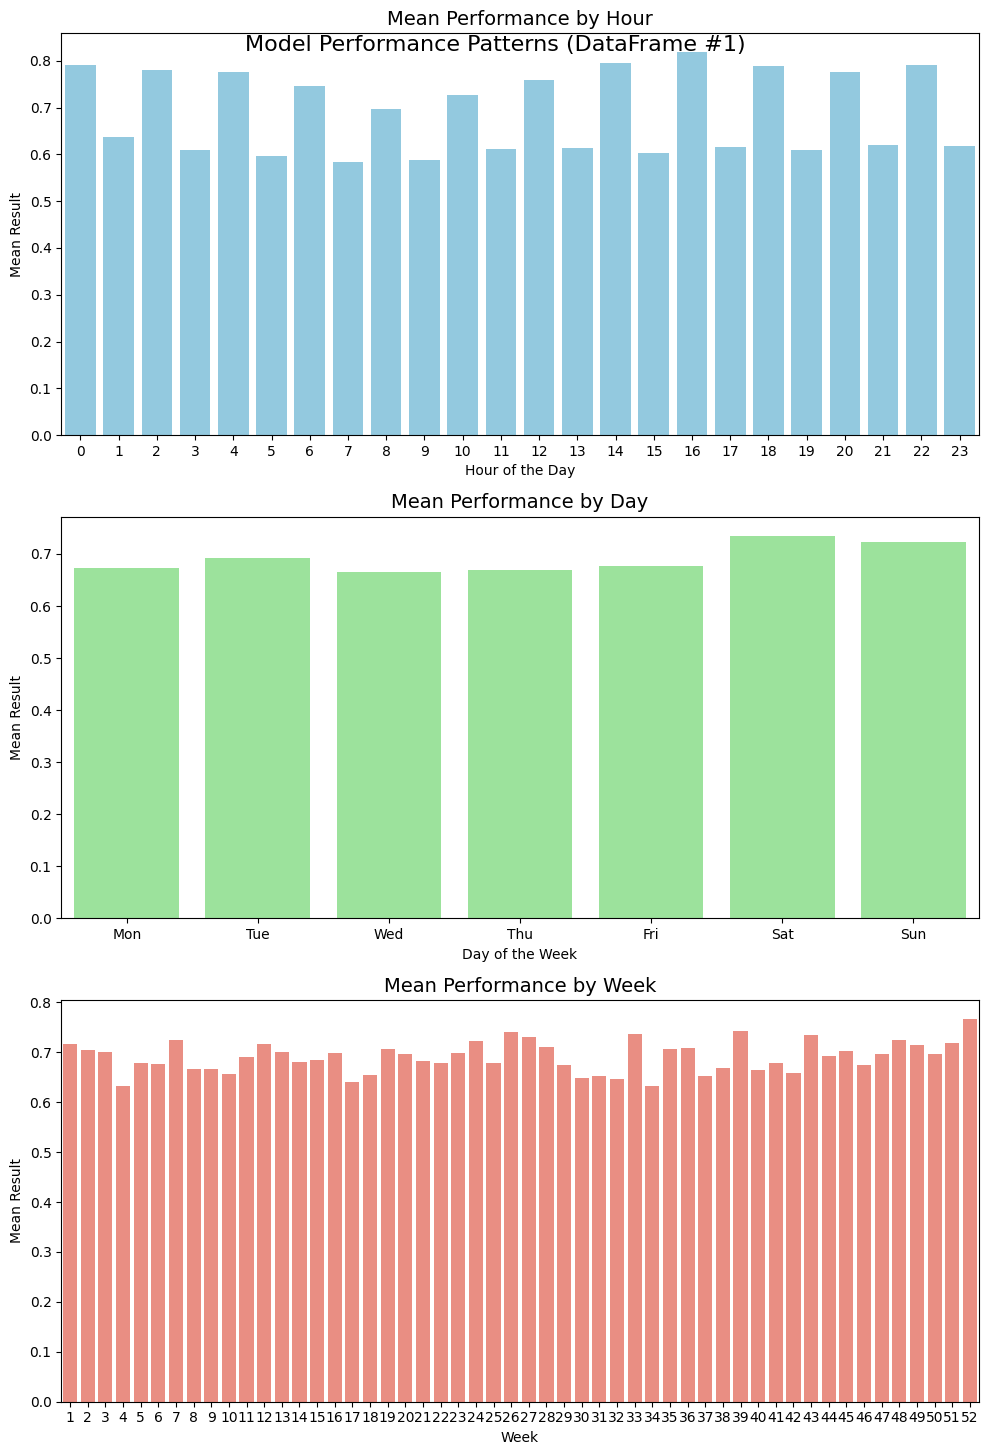

<ipython-input-11-294695c77ee5>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


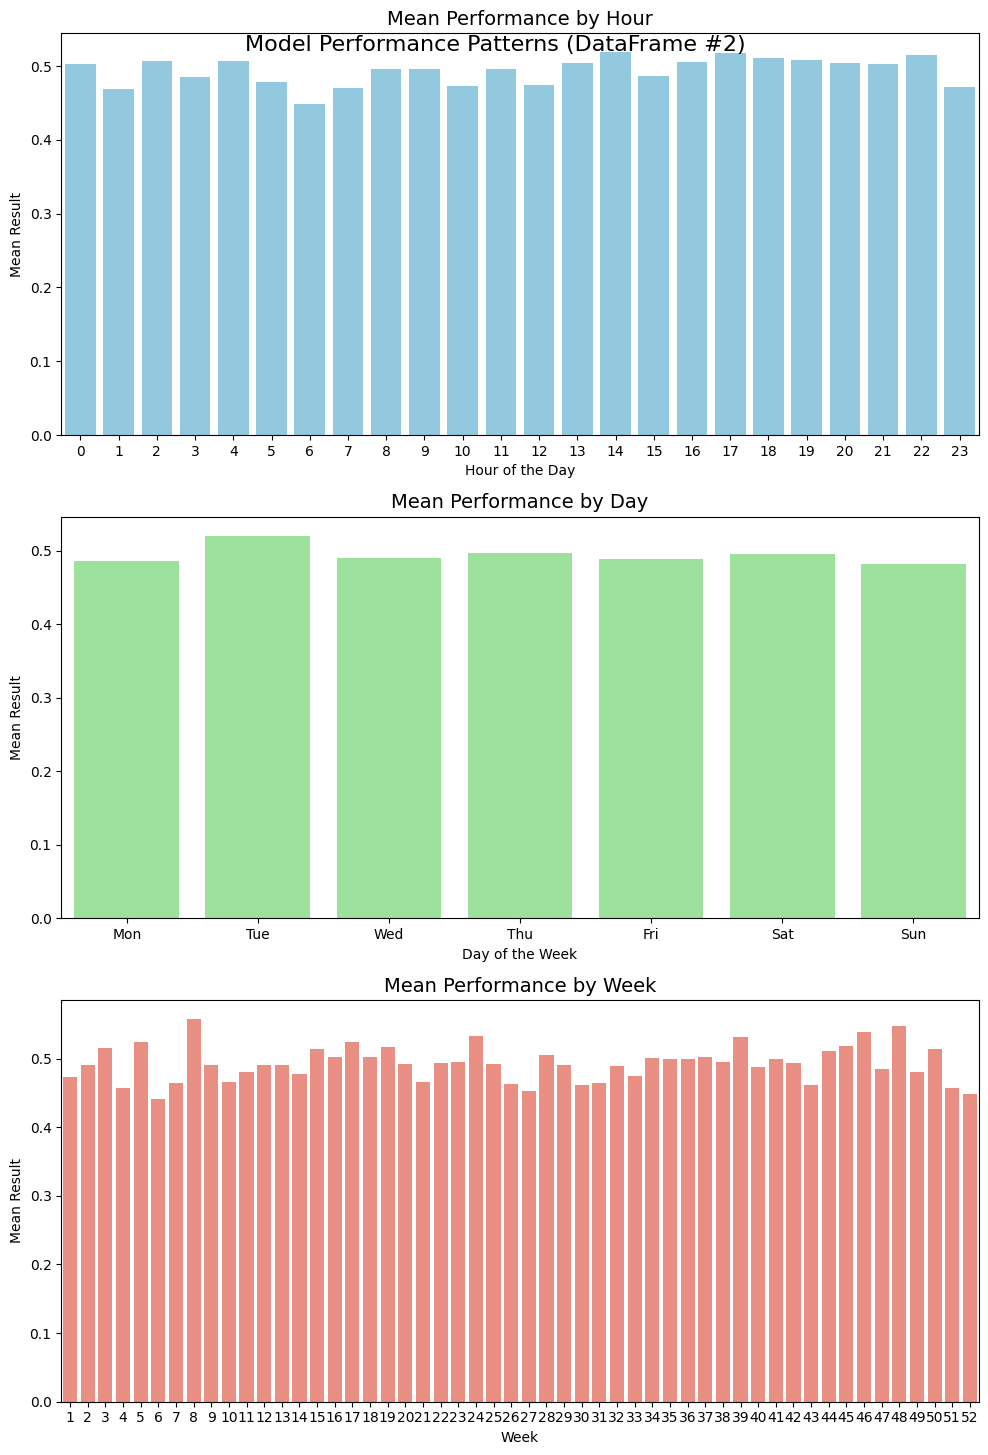

<ipython-input-11-294695c77ee5>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


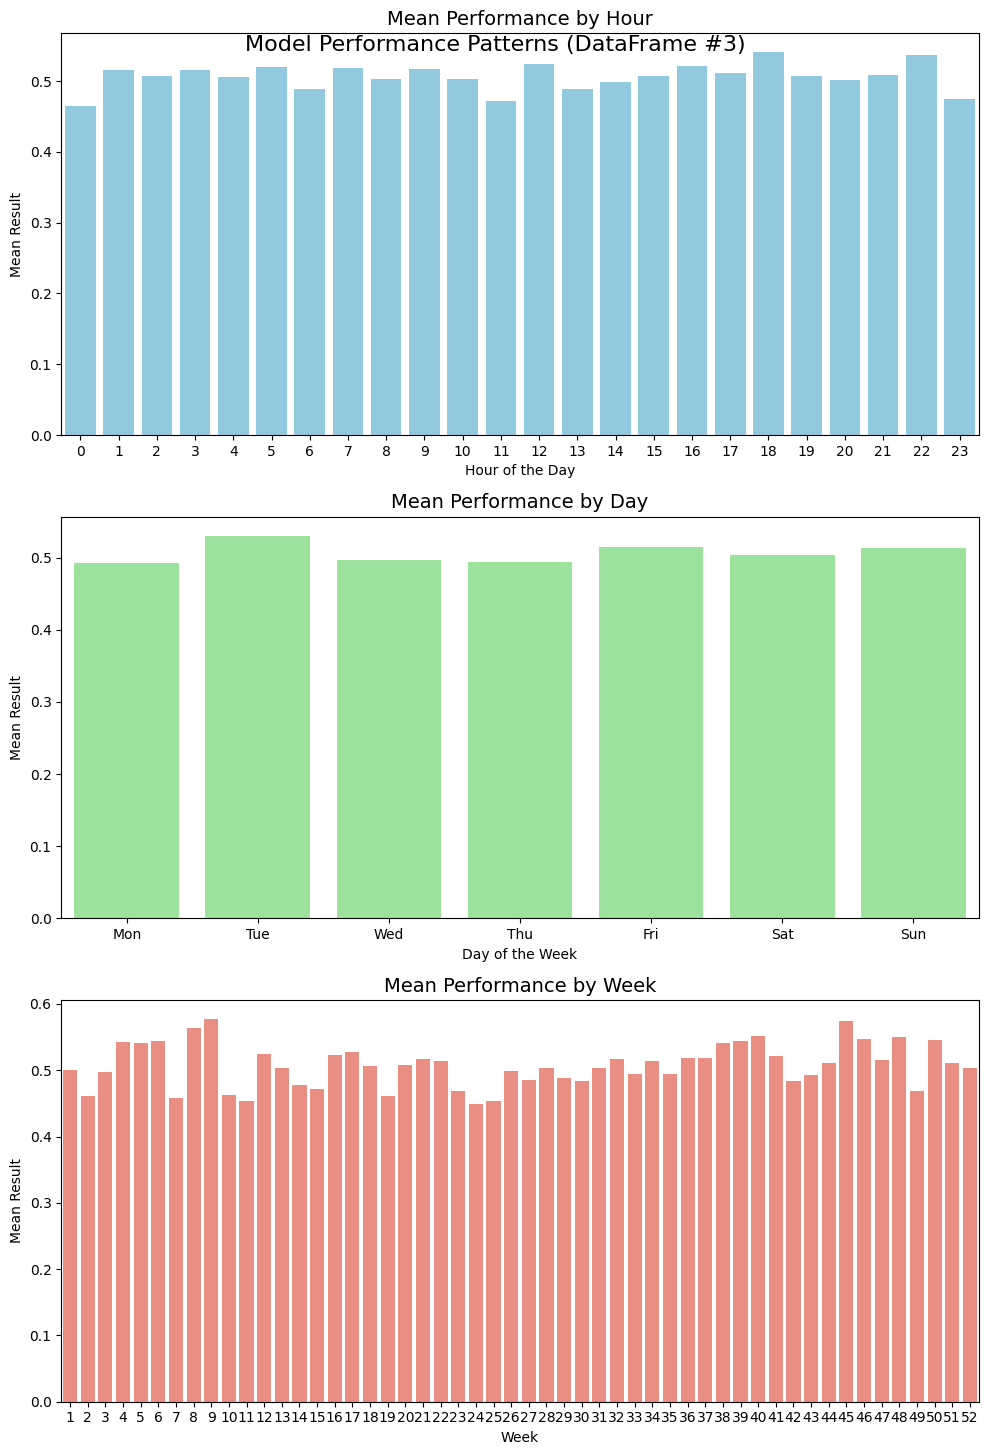

<ipython-input-11-294695c77ee5>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


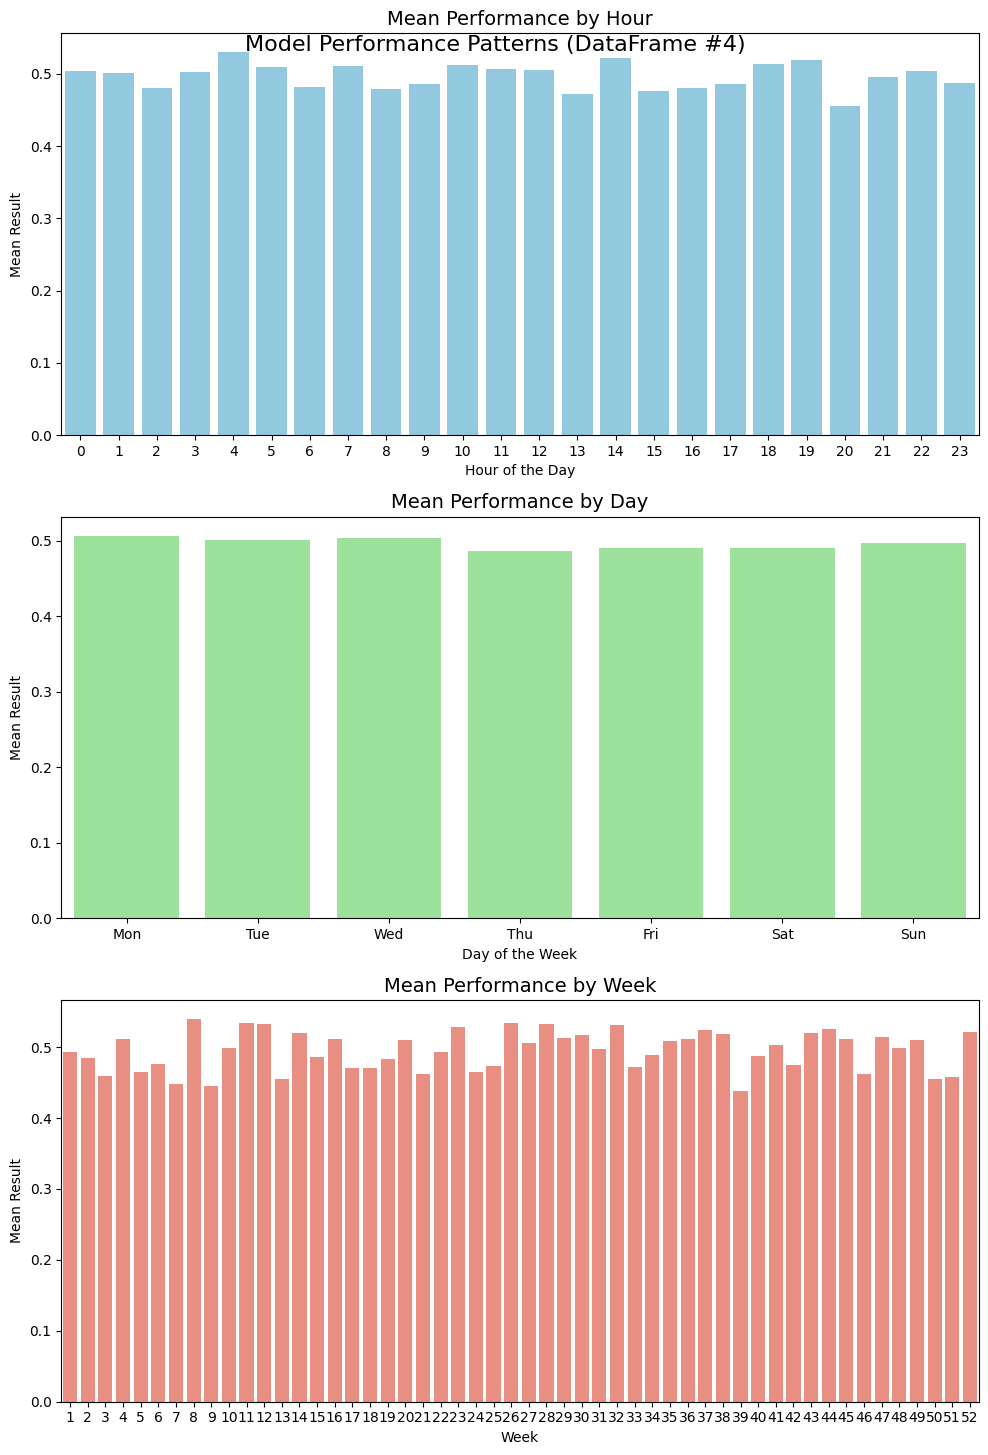

<ipython-input-11-294695c77ee5>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


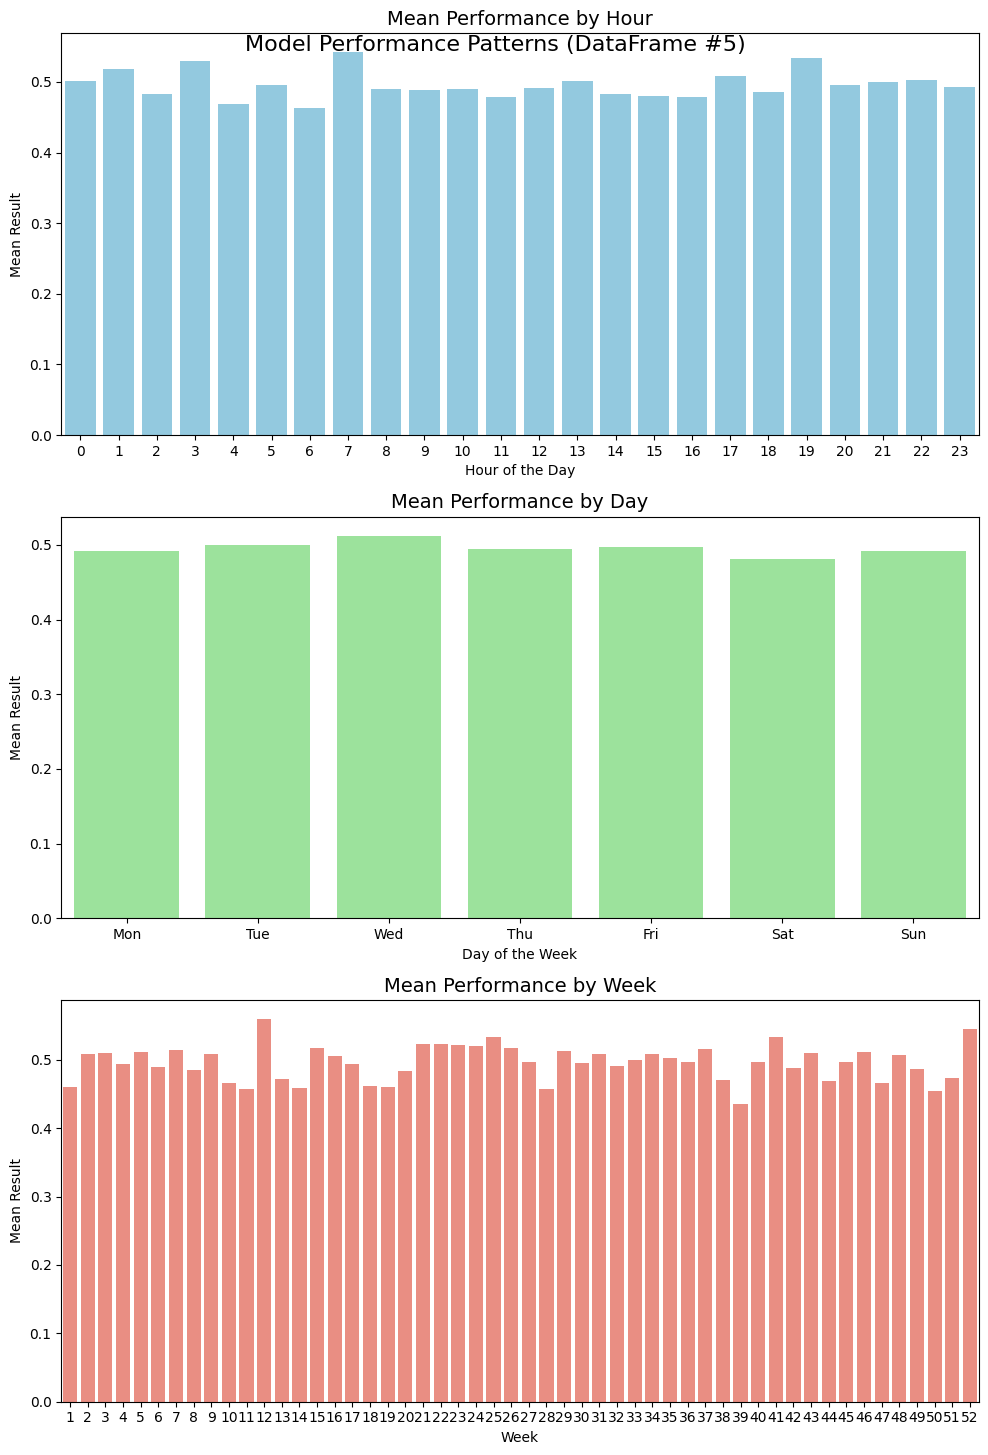

<ipython-input-11-294695c77ee5>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


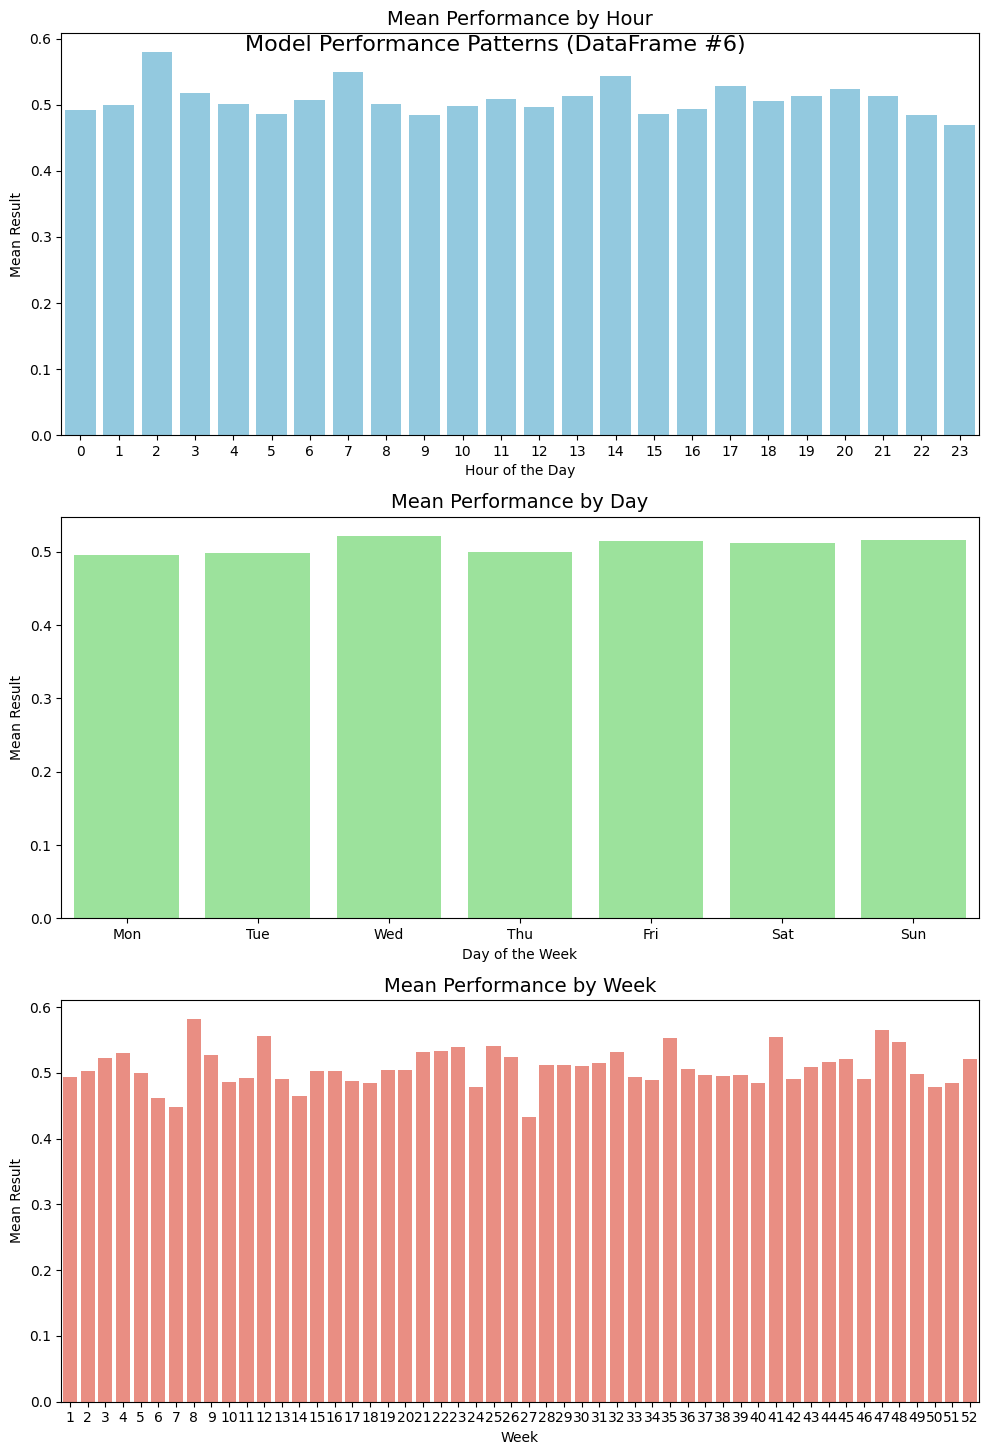

<ipython-input-11-294695c77ee5>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


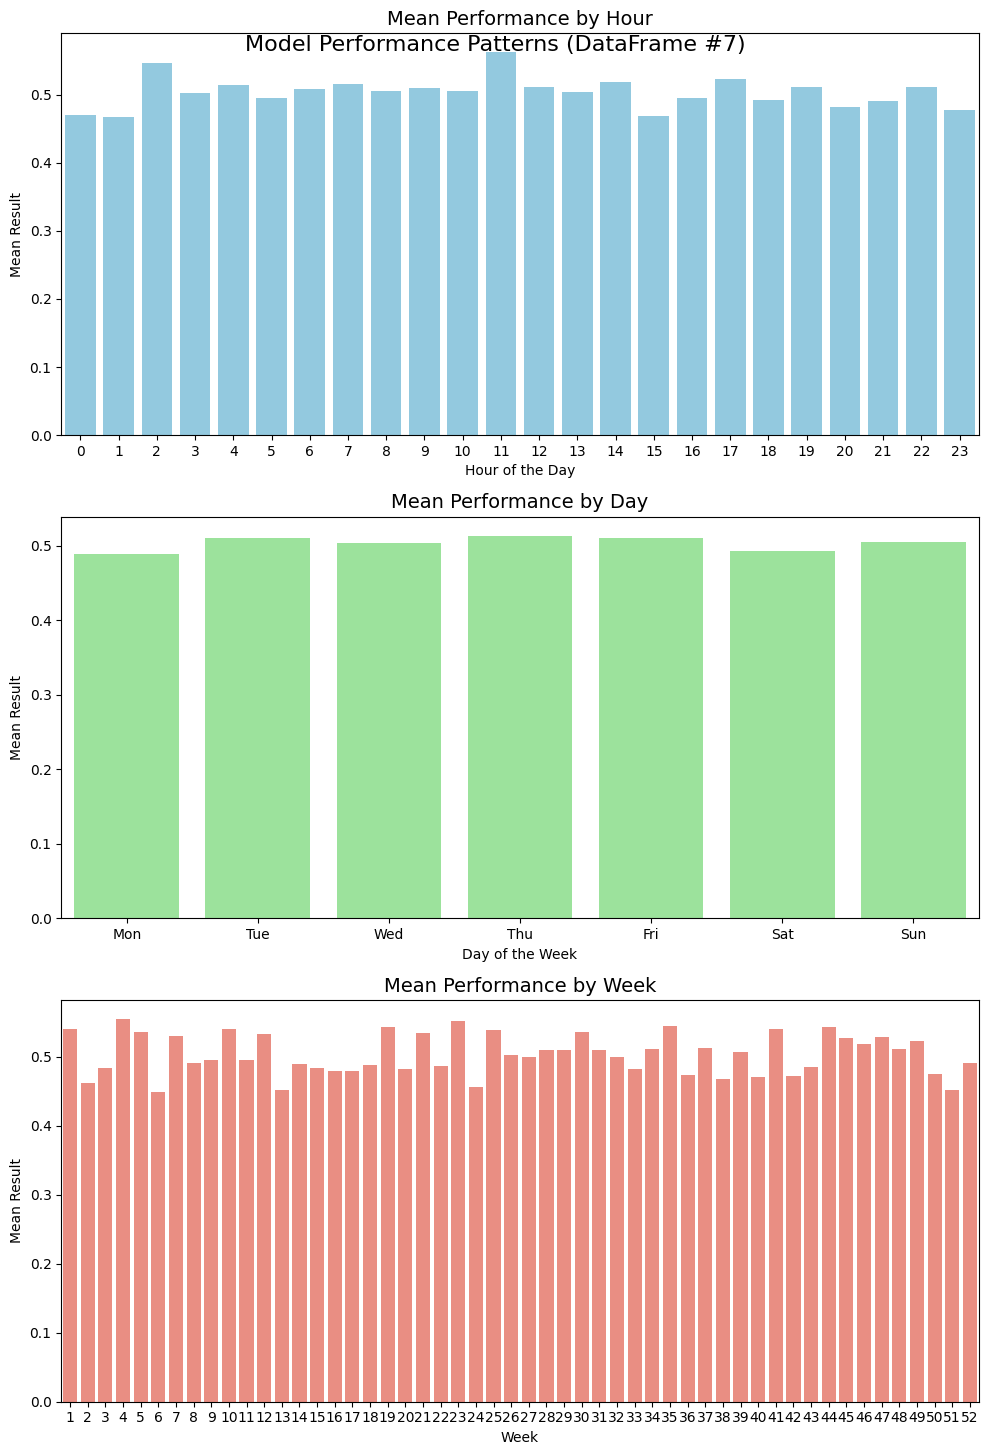

<ipython-input-11-294695c77ee5>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


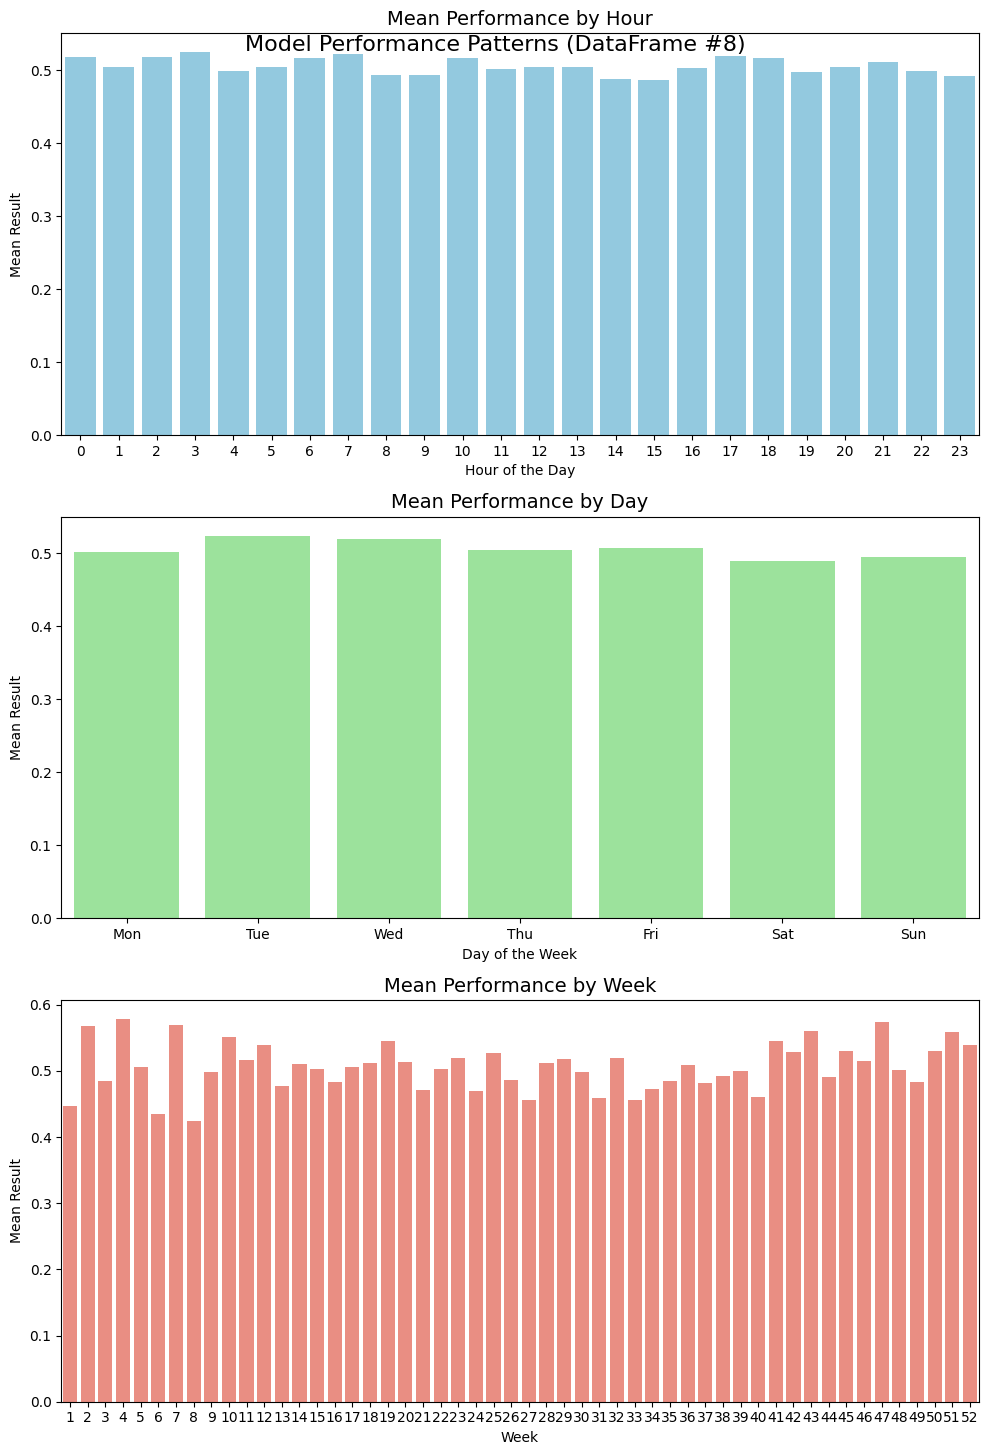

<ipython-input-11-294695c77ee5>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


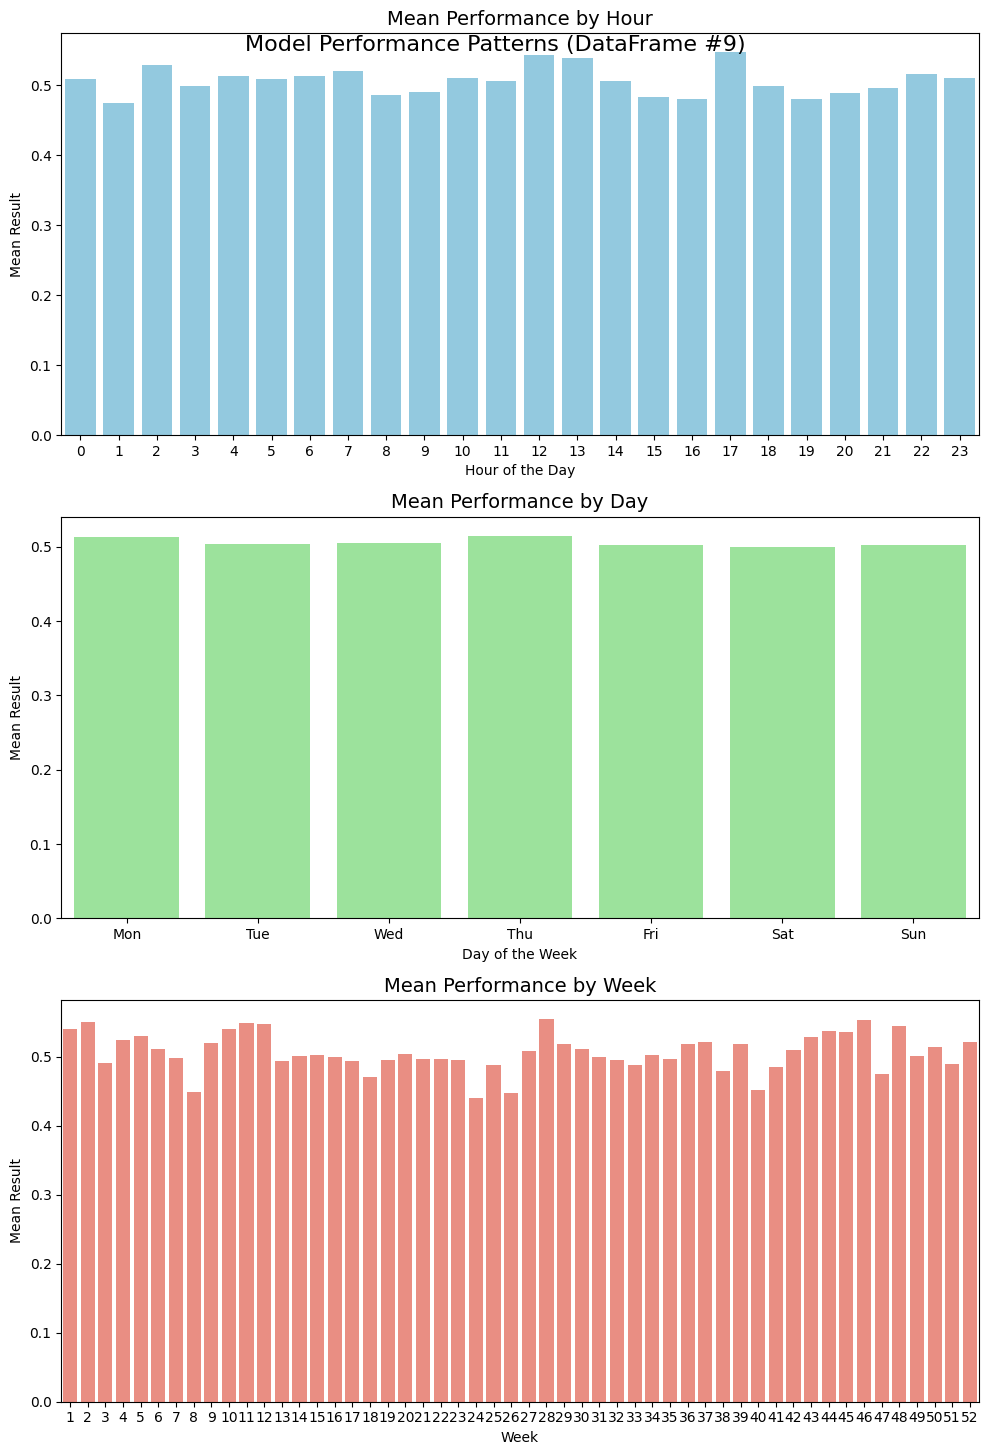

<ipython-input-11-294695c77ee5>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


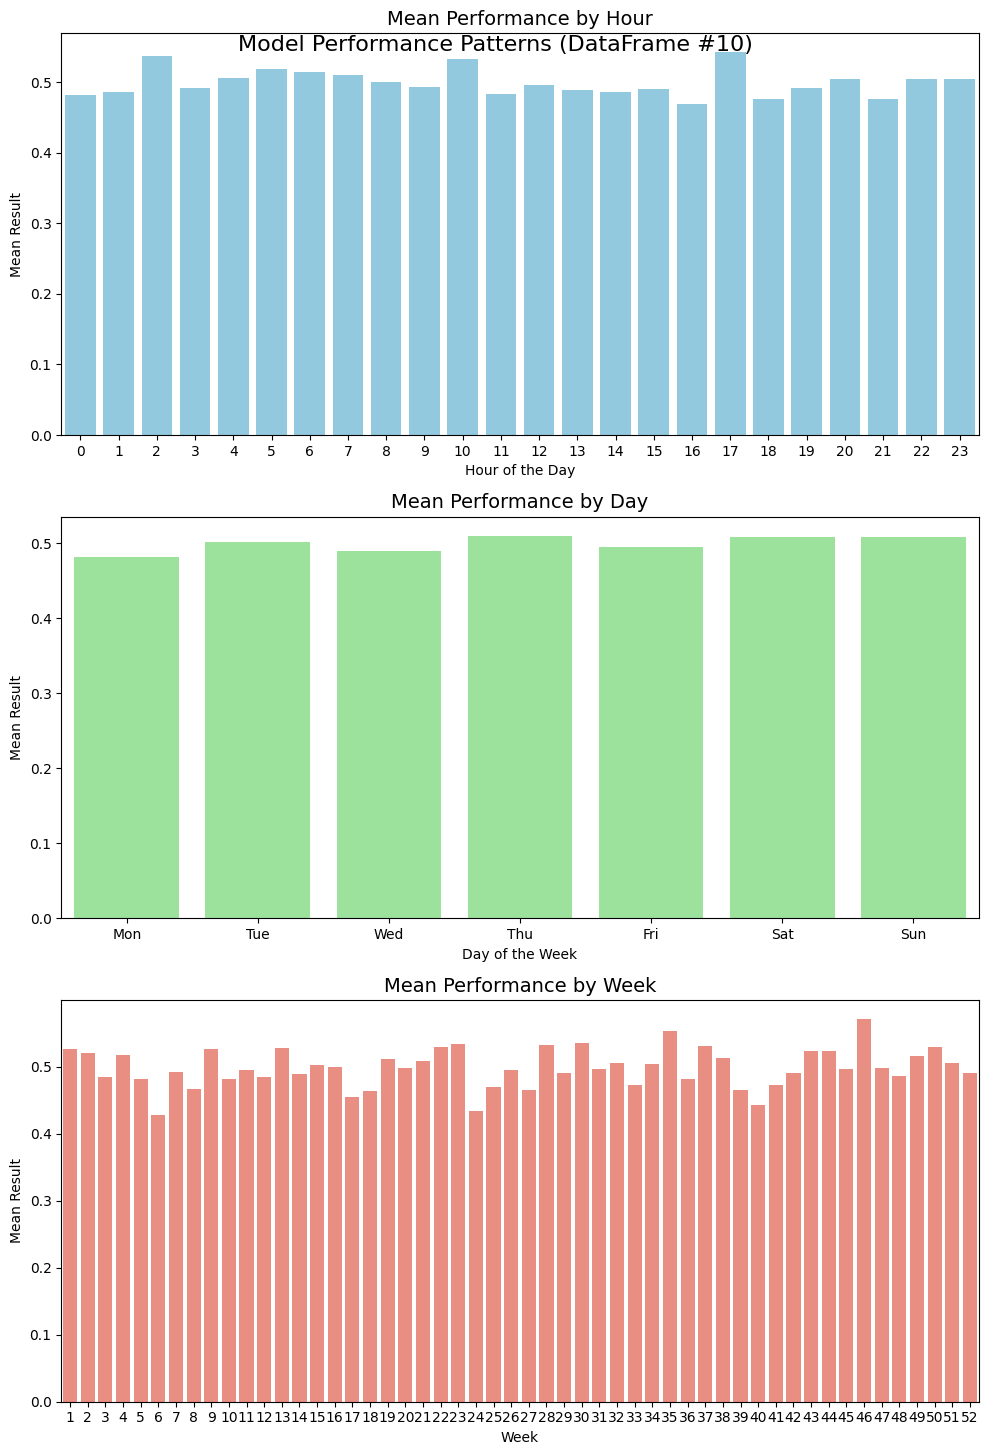

<ipython-input-11-294695c77ee5>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


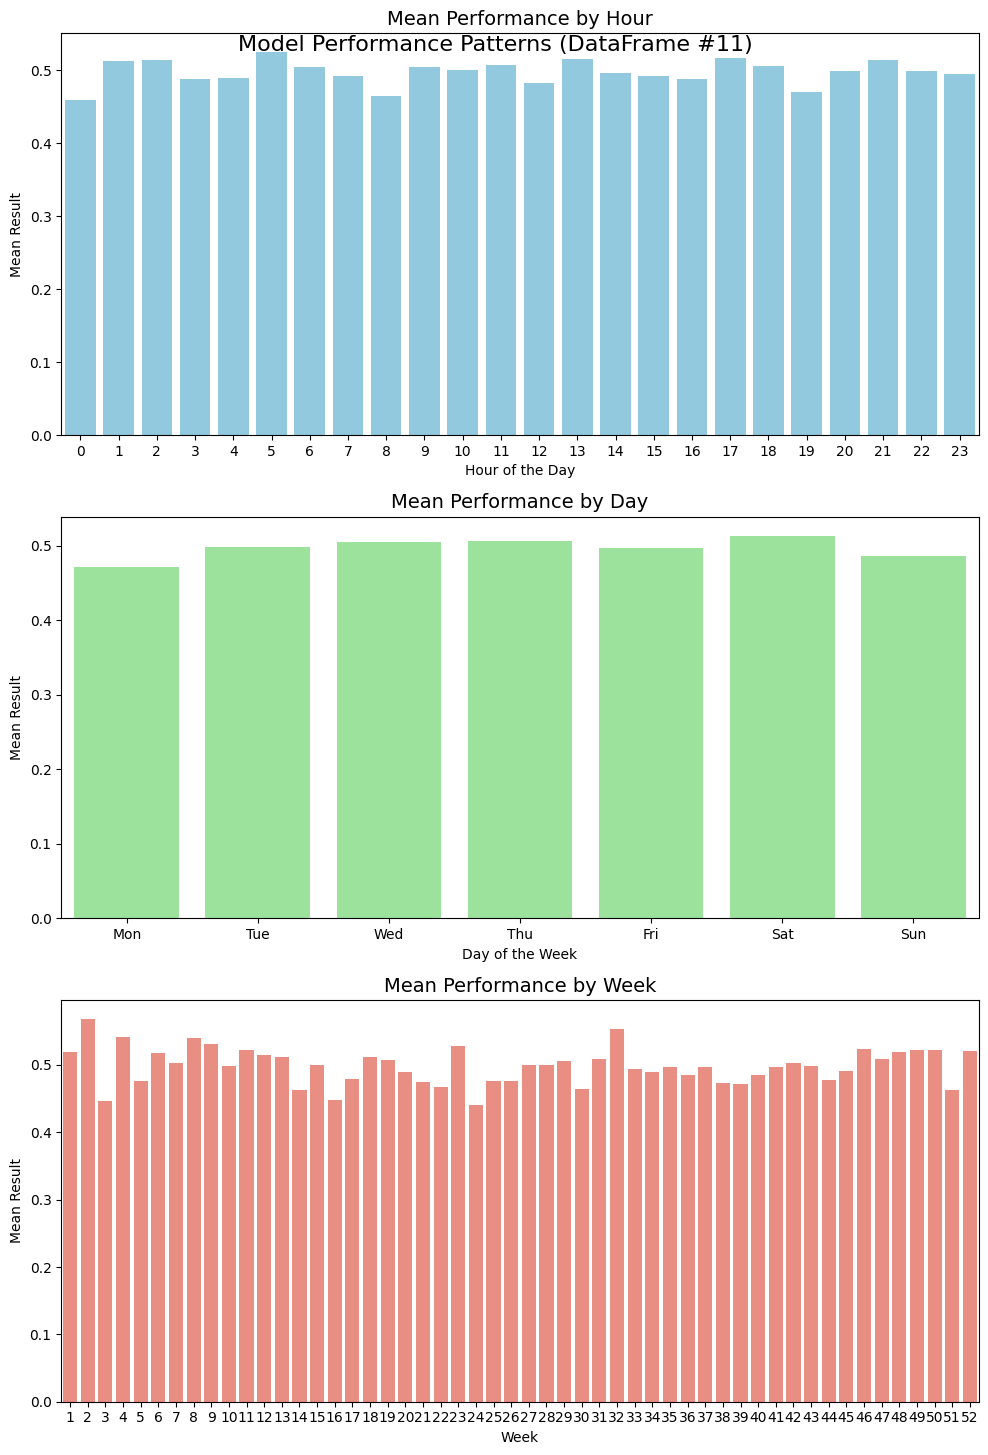

<ipython-input-11-294695c77ee5>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


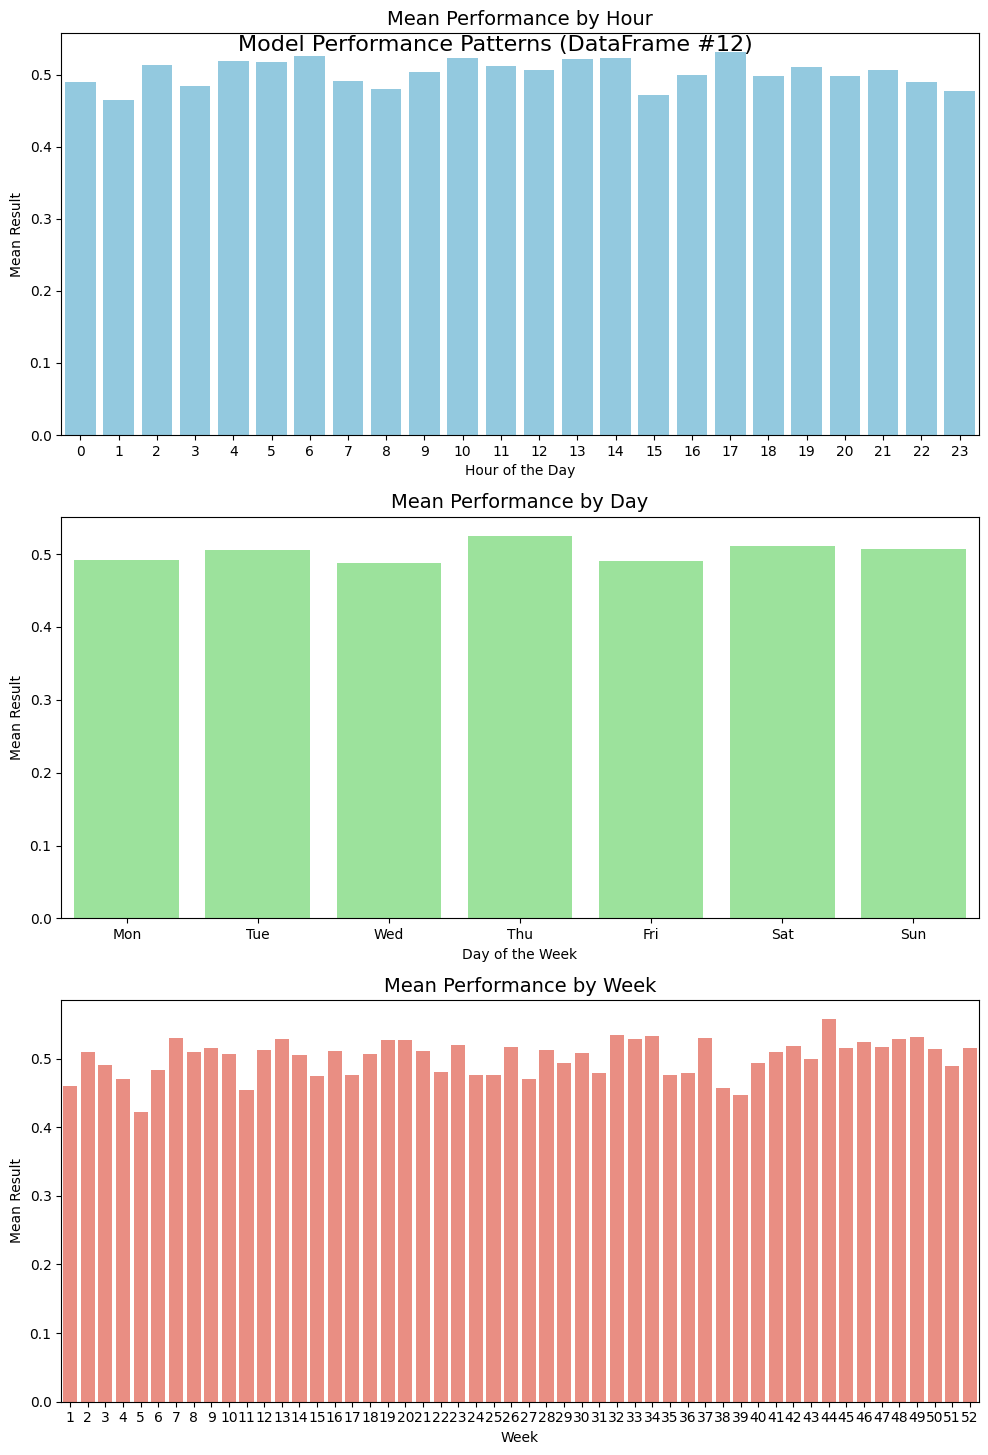

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: assuming Hour is [0..23], Day is [0..6], Week is a numeric week index.
# If these are not the correct ranges or formats, adjust accordingly.

for i, df in enumerate(predictions_dfs.values(), 1):
    # Group and compute mean performance
    hour_performance = df.groupby('Hour')['Result'].mean()  # Keep natural hourly order
    day_performance = df.groupby('Day')['Result'].mean()    # Keep natural daily order
    week_performance = df.groupby('Week')['Result'].mean()  # Keep natural weekly order

    # Create a figure with three subplots
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    fig.suptitle(f'Model Performance Patterns (DataFrame #{i})', fontsize=16, y=0.95)

    # Hourly performance plot
    sns.barplot(x=hour_performance.index, y=hour_performance.values, ax=axs[0], color="skyblue")
    axs[0].set_title('Mean Performance by Hour', fontsize=14)
    axs[0].set_xlabel('Hour of the Day')
    axs[0].set_ylabel('Mean Result')

    # Daily performance plot
    sns.barplot(x=day_performance.index, y=day_performance.values, ax=axs[1], color="lightgreen")
    axs[1].set_title('Mean Performance by Day', fontsize=14)
    axs[1].set_xlabel('Day of the Week')
    axs[1].set_ylabel('Mean Result')
    # If day coding is known (e.g., 0=Monday), add custom labels:
    axs[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

    # Weekly performance plot
    sns.barplot(x=week_performance.index, y=week_performance.values, ax=axs[2], color="salmon")
    axs[2].set_title('Mean Performance by Week', fontsize=14)
    axs[2].set_xlabel('Week')
    axs[2].set_ylabel('Mean Result')

    plt.tight_layout()
    plt.show()